# 🎯 Baseline Models Evaluation for Telco Customer Churn Prediction

This notebook systematically evaluates multiple machine learning models using the feature-engineered dataset to identify the most promising candidates for predicting customer churn.

## 📋 Objectives:
1. Load and inspect the feature-engineered dataset
2. Evaluate 10+ classification models with default parameters
3. Perform 5-fold cross-validation with comprehensive metrics
4. Identify top 3 performing models for further optimization

## 📦 Import Required Libraries

In [27]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Advanced boosting models
%pip install lightgbm catboost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Model evaluation and validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    roc_auc_score, classification_report, confusion_matrix
)

# Data preprocessing
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
✅ All libraries imported successfully!



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📊 1. Load the Feature-Engineered Dataset

In [28]:
# Load the feature-engineered dataset
data = pd.read_csv('../Data/output/feature_engineered_train.csv')

print("📈 Dataset Loaded Successfully!")
print("="*50)
print(f"Dataset Shape: {data.shape}")
print(f"Number of Features: {data.shape[1] - 2}")  # Excluding customerID and Churn
print(f"Number of Samples: {data.shape[0]}")

# Display basic information
print("\n📋 Dataset Info:")
print(data.info())

# Check for missing values
missing_values = data.isnull().sum()
print(f"\n🔍 Missing Values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print("Missing values by column:")
    print(missing_values[missing_values > 0])
else:
    print("✅ No missing values found!")

# Display first few rows
print("\n📊 First 5 rows:")
display(data.head())

📈 Dataset Loaded Successfully!
Dataset Shape: (5625, 22)
Number of Features: 20
Number of Samples: 5625

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Contract                          5625 non-null   float64
 1   MonthlyCharges                    5625 non-null   float64
 2   TotalCharges                      5625 non-null   float64
 3   poly_tenure MonthlyCharges        5625 non-null   float64
 4   poly_tenure TotalCharges          5625 non-null   float64
 5   poly_MonthlyCharges^2             5625 non-null   float64
 6   poly_MonthlyCharges TotalCharges  5625 non-null   float64
 7   poly_TotalCharges^2               5625 non-null   float64
 8   tenure_x_monthly                  5625 non-null   float64
 9   monthly_x_total                   5625 non-null   float64
 10  tenure_x_to

,Contract,MonthlyCharges,TotalCharges,poly_tenure MonthlyCharges,poly_tenure TotalCharges,poly_MonthlyCharges^2,poly_MonthlyCharges TotalCharges,poly_TotalCharges^2,tenure_x_monthly,monthly_x_total,tenure_x_total,AvgMonthlyCharge,StabilityIndex,log_TotalCharges,normalized_tenure,normalized_StabilityIndex,standardized_MonthlyCharges,standardized_AvgMonthlyCharge,label_Contract,freq_PaymentMethod,customerID,Churn
0,2.0,94.55,6078.75,6145.75,395118.75,8939.7025,574745.8125,3.695120e+07,6145.75,574745.8125,395118.75,93.519231,130.0,8.712719,0.901408,0.902098,0.981556,0.943761,2.0,0.216000,1830-GGFNM,No
1,0.0,35.75,1022.50,929.50,26585.00,1278.0625,36554.3750,1.045506e+06,929.50,36554.3750,26585.00,39.326923,26.0,6.930983,0.352113,0.174825,-0.971546,-0.849298,0.0,0.339022,4501-VCPFK,No
2,2.0,90.20,6297.65,6133.60,428240.20,8136.0400,568048.0300,3.966040e+07,6133.60,568048.0300,428240.20,92.612500,136.0,8.748091,0.943662,0.944056,0.837066,0.913760,2.0,0.216000,8871-JLMHM,No
3,0.0,84.30,235.05,252.90,705.15,7106.4900,19814.7150,5.524850e+04,252.90,19814.7150,705.15,78.350000,3.0,5.464044,0.028169,0.013986,0.641092,0.441857,0.0,0.339022,0225-ZORZP,No
4,0.0,40.65,2070.75,1991.85,101466.75,1652.4225,84175.9875,4.288006e+06,1991.85,84175.9875,101466.75,42.260204,49.0,7.636149,0.676056,0.335664,-0.808787,-0.752245,0.0,0.219556,1530-ZTDOZ,No


## 🎯 2. Define Inputs and Target Variable

Target variable encoded: {'No': np.int64(0), 'Yes': np.int64(1)}
🎯 Data Preparation Complete!
Features (X) shape: (5625, 20)
Target (y) shape: (5625,)
Feature names: ['Contract', 'MonthlyCharges', 'TotalCharges', 'poly_tenure MonthlyCharges', 'poly_tenure TotalCharges', 'poly_MonthlyCharges^2', 'poly_MonthlyCharges TotalCharges', 'poly_TotalCharges^2', 'tenure_x_monthly', 'monthly_x_total', 'tenure_x_total', 'AvgMonthlyCharge', 'StabilityIndex', 'log_TotalCharges', 'normalized_tenure', 'normalized_StabilityIndex', 'standardized_MonthlyCharges', 'standardized_AvgMonthlyCharge', 'label_Contract', 'freq_PaymentMethod']

📊 Target Class Distribution:
Class 0 (No Churn): 4,130 samples (73.4%)
Class 1 (Churn): 1,495 samples (26.6%)
⚠️  Dataset is imbalanced (ratio: 0.36)


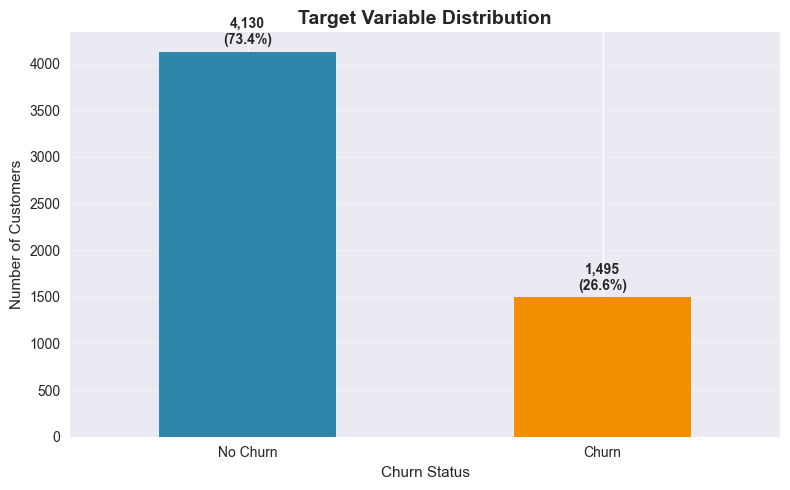

In [29]:
# Separate features (X) from target variable (y)
# Exclude non-predictive columns
exclude_cols = ['customerID', 'Churn']
X = data.drop(columns=exclude_cols)
y = data['Churn']

# Convert target to binary (0/1) if it's categorical
if y.dtype == 'object' or y.dtype.name == 'category':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print(f"Target variable encoded: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print("🎯 Data Preparation Complete!")
print("="*40)
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

# Display target class distribution
print("\n📊 Target Class Distribution:")
target_counts = pd.Series(y).value_counts().sort_index()
target_percentages = pd.Series(y).value_counts(normalize=True).sort_index() * 100

print(f"Class 0 (No Churn): {target_counts[0]:,} samples ({target_percentages[0]:.1f}%)")
print(f"Class 1 (Churn): {target_counts[1]:,} samples ({target_percentages[1]:.1f}%)")

# Check if dataset is balanced
class_ratio = target_counts.min() / target_counts.max()
if class_ratio < 0.7:
    print(f"⚠️  Dataset is imbalanced (ratio: {class_ratio:.2f})")
else:
    print(f"✅ Dataset is reasonably balanced (ratio: {class_ratio:.2f})")

# Visualize target distribution
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color=['#2E86AB', '#F18F01'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(target_counts):
    plt.text(i, v + 50, f'{v:,}\n({target_percentages[i]:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

## 🤖 3. Candidate Model Selection

We'll evaluate 12 popular classification models with their default parameters to establish baseline performance.

In [30]:
# Define candidate models with default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=False),
    'Support Vector Classifier': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42)
}

print("🤖 Candidate Models Selected:")
print("="*40)
for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i:2d}. {name}")
    print(f"    Library: {model.__class__.__module__.split('.')[0]}")
    print(f"    Class: {model.__class__.__name__}")

print(f"\n✅ Total Models: {len(models)}")

🤖 Candidate Models Selected:
 1. Logistic Regression
    Library: sklearn
    Class: LogisticRegression
 2. Decision Tree
    Library: sklearn
    Class: DecisionTreeClassifier
 3. Random Forest
    Library: sklearn
    Class: RandomForestClassifier
 4. XGBoost
    Library: xgboost
    Class: XGBClassifier
 5. LightGBM
    Library: lightgbm
    Class: LGBMClassifier
 6. CatBoost
    Library: catboost
    Class: CatBoostClassifier
 7. Support Vector Classifier
    Library: sklearn
    Class: SVC
 8. Naive Bayes
    Library: sklearn
    Class: GaussianNB
 9. K-Nearest Neighbors
    Library: sklearn
    Class: KNeighborsClassifier
10. Gradient Boosting
    Library: sklearn
    Class: GradientBoostingClassifier
11. AdaBoost
    Library: sklearn
    Class: AdaBoostClassifier
12. Extra Trees
    Library: sklearn
    Class: ExtraTreesClassifier

✅ Total Models: 12


## 📈 4. Cross-Validation & Performance Evaluation

We'll perform 5-fold stratified cross-validation to ensure robust evaluation across all models.

In [31]:
# Set up stratified k-fold cross-validation
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = ['accuracy', 'precision', 'recall', 'roc_auc']

# Initialize results storage
results = []

print("🔄 Starting Cross-Validation Evaluation...")
print("="*50)

# Evaluate each model
for model_name, model in models.items():
    print(f"\n🔍 Evaluating: {model_name}")
    
    # Perform cross-validation for each metric
    model_results = {'Model': model_name}
    
    for metric in scoring_metrics:
        try:
            # Perform cross-validation
            cv_scores = cross_val_score(model, X, y, cv=skf, scoring=metric, n_jobs=-1)
            
            # Calculate mean and standard deviation
            mean_score = cv_scores.mean()
            std_score = cv_scores.std()
            
            model_results[f'{metric.upper()}_mean'] = mean_score
            model_results[f'{metric.upper()}_std'] = std_score
            
            print(f"  {metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")
            
        except Exception as e:
            print(f"  ❌ Error with {metric}: {str(e)}")
            model_results[f'{metric.upper()}_mean'] = np.nan
            model_results[f'{metric.upper()}_std'] = np.nan
    
    results.append(model_results)
    print(f"  ✅ {model_name} evaluation complete!")

print("\n🎉 All model evaluations completed!")

🔄 Starting Cross-Validation Evaluation...

🔍 Evaluating: Logistic Regression
  ACCURACY: 0.7888 ± 0.0063
  PRECISION: 0.6536 ± 0.0124
  PRECISION: 0.6536 ± 0.0124
  RECALL: 0.4375 ± 0.0413
  ROC_AUC: 0.8217 ± 0.0087
  ✅ Logistic Regression evaluation complete!

🔍 Evaluating: Decision Tree
  RECALL: 0.4375 ± 0.0413
  ROC_AUC: 0.8217 ± 0.0087
  ✅ Logistic Regression evaluation complete!

🔍 Evaluating: Decision Tree
  ACCURACY: 0.7275 ± 0.0064
  ACCURACY: 0.7275 ± 0.0064
  PRECISION: 0.4876 ± 0.0119
  RECALL: 0.4977 ± 0.0241
  PRECISION: 0.4876 ± 0.0119
  RECALL: 0.4977 ± 0.0241
  ROC_AUC: 0.6588 ± 0.0107
  ✅ Decision Tree evaluation complete!

🔍 Evaluating: Random Forest
  ROC_AUC: 0.6588 ± 0.0107
  ✅ Decision Tree evaluation complete!

🔍 Evaluating: Random Forest
  ACCURACY: 0.7723 ± 0.0078
  ACCURACY: 0.7723 ± 0.0078
  PRECISION: 0.5897 ± 0.0211
  PRECISION: 0.5897 ± 0.0211
  RECALL: 0.4742 ± 0.0218
  RECALL: 0.4742 ± 0.0218
  ROC_AUC: 0.8038 ± 0.0134
  ✅ Random Forest evaluation compl

  ACCURACY: 0.7909 ± 0.0055
  PRECISION: 0.6394 ± 0.0130
  RECALL: 0.4903 ± 0.0330
  ROC_AUC: 0.8356 ± 0.0091
  ✅ CatBoost evaluation complete!

🔍 Evaluating: Support Vector Classifier
  ACCURACY: 0.7342 ± 0.0000
  PRECISION: 0.0000 ± 0.0000
  RECALL: 0.0000 ± 0.0000
  ROC_AUC: 0.5739 ± 0.0483
  ✅ Support Vector Classifier evaluation complete!

🔍 Evaluating: Naive Bayes
  ACCURACY: 0.4855 ± 0.0191
  PRECISION: 0.3175 ± 0.0113
  RECALL: 0.8127 ± 0.0209
  ROC_AUC: 0.7280 ± 0.0212
  ✅ Naive Bayes evaluation complete!

🔍 Evaluating: K-Nearest Neighbors
  ACCURACY: 0.7662 ± 0.0059
  PRECISION: 0.5786 ± 0.0149
  RECALL: 0.4441 ± 0.0237
  ROC_AUC: 0.7408 ± 0.0091
  ✅ K-Nearest Neighbors evaluation complete!

🔍 Evaluating: Gradient Boosting
  ACCURACY: 0.7916 ± 0.0073
  PRECISION: 0.6392 ± 0.0115
  RECALL: 0.4950 ± 0.0346
  ROC_AUC: 0.8390 ± 0.0074
  ✅ Gradient Boosting evaluation complete!

🔍 Evaluating: AdaBoost
  ACCURACY: 0.7884 ± 0.0071
  PRECISION: 0.6324 ± 0.0191
  RECALL: 0.4883 ± 0.01

## 📊 Results Summary & Comparison

In [32]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Create formatted results table
display_df = results_df.copy()
display_df['Accuracy (Mean ± Std)'] = display_df.apply(
    lambda row: f"{row['ACCURACY_mean']:.4f} ± {row['ACCURACY_std']:.4f}", axis=1
)
display_df['Precision (Mean ± Std)'] = display_df.apply(
    lambda row: f"{row['PRECISION_mean']:.4f} ± {row['PRECISION_std']:.4f}", axis=1
)
display_df['Recall (Mean ± Std)'] = display_df.apply(
    lambda row: f"{row['RECALL_mean']:.4f} ± {row['RECALL_std']:.4f}", axis=1
)
display_df['AUC-ROC (Mean ± Std)'] = display_df.apply(
    lambda row: f"{row['ROC_AUC_mean']:.4f} ± {row['ROC_AUC_std']:.4f}", axis=1
)

# Select columns for final display
final_display = display_df[[
    'Model', 
    'Accuracy (Mean ± Std)', 
    'Precision (Mean ± Std)', 
    'Recall (Mean ± Std)', 
    'AUC-ROC (Mean ± Std)'
]]

print("📊 BASELINE MODELS PERFORMANCE SUMMARY")
print("="*80)
display(final_display)

# Sort by AUC-ROC for ranking
results_sorted = results_df.sort_values('ROC_AUC_mean', ascending=False)

print("\n🏆 MODEL RANKING (by AUC-ROC):")
print("-" * 40)
for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    print(f"{i:2d}. {row['Model']:<25} | AUC-ROC: {row['ROC_AUC_mean']:.4f}")

📊 BASELINE MODELS PERFORMANCE SUMMARY


,Model,Accuracy (Mean ± Std),Precision (Mean ± Std),Recall (Mean ± Std),AUC-ROC (Mean ± Std)
0,Logistic Regression,0.7888 ± 0.0063,0.6536 ± 0.0124,0.4375 ± 0.0413,0.8217 ± 0.0087
1,Decision Tree,0.7275 ± 0.0064,0.4876 ± 0.0119,0.4977 ± 0.0241,0.6588 ± 0.0107
2,Random Forest,0.7723 ± 0.0078,0.5897 ± 0.0211,0.4742 ± 0.0218,0.8038 ± 0.0134
3,XGBoost,0.7749 ± 0.0106,0.5922 ± 0.0321,0.5017 ± 0.0301,0.8177 ± 0.0096
4,LightGBM,0.7812 ± 0.0029,0.6088 ± 0.0085,0.4957 ± 0.0339,0.8242 ± 0.0081
5,CatBoost,0.7909 ± 0.0055,0.6394 ± 0.0130,0.4903 ± 0.0330,0.8356 ± 0.0091
6,Support Vector Classifier,0.7342 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000,0.5739 ± 0.0483
7,Naive Bayes,0.4855 ± 0.0191,0.3175 ± 0.0113,0.8127 ± 0.0209,0.7280 ± 0.0212
8,K-Nearest Neighbors,0.7662 ± 0.0059,0.5786 ± 0.0149,0.4441 ± 0.0237,0.7408 ± 0.0091
9,Gradient Boosting,0.7916 ± 0.0073,0.6392 ± 0.0115,0.4950 ± 0.0346,0.8390 ± 0.0074



🏆 MODEL RANKING (by AUC-ROC):
----------------------------------------
 1. Gradient Boosting         | AUC-ROC: 0.8390
 2. CatBoost                  | AUC-ROC: 0.8356
 3. AdaBoost                  | AUC-ROC: 0.8345
 4. LightGBM                  | AUC-ROC: 0.8242
 5. Logistic Regression       | AUC-ROC: 0.8217
 6. XGBoost                   | AUC-ROC: 0.8177
 7. Random Forest             | AUC-ROC: 0.8038
 8. Extra Trees               | AUC-ROC: 0.7821
 9. K-Nearest Neighbors       | AUC-ROC: 0.7408
10. Naive Bayes               | AUC-ROC: 0.7280
11. Decision Tree             | AUC-ROC: 0.6588
12. Support Vector Classifier | AUC-ROC: 0.5739


## 📈 Performance Visualization

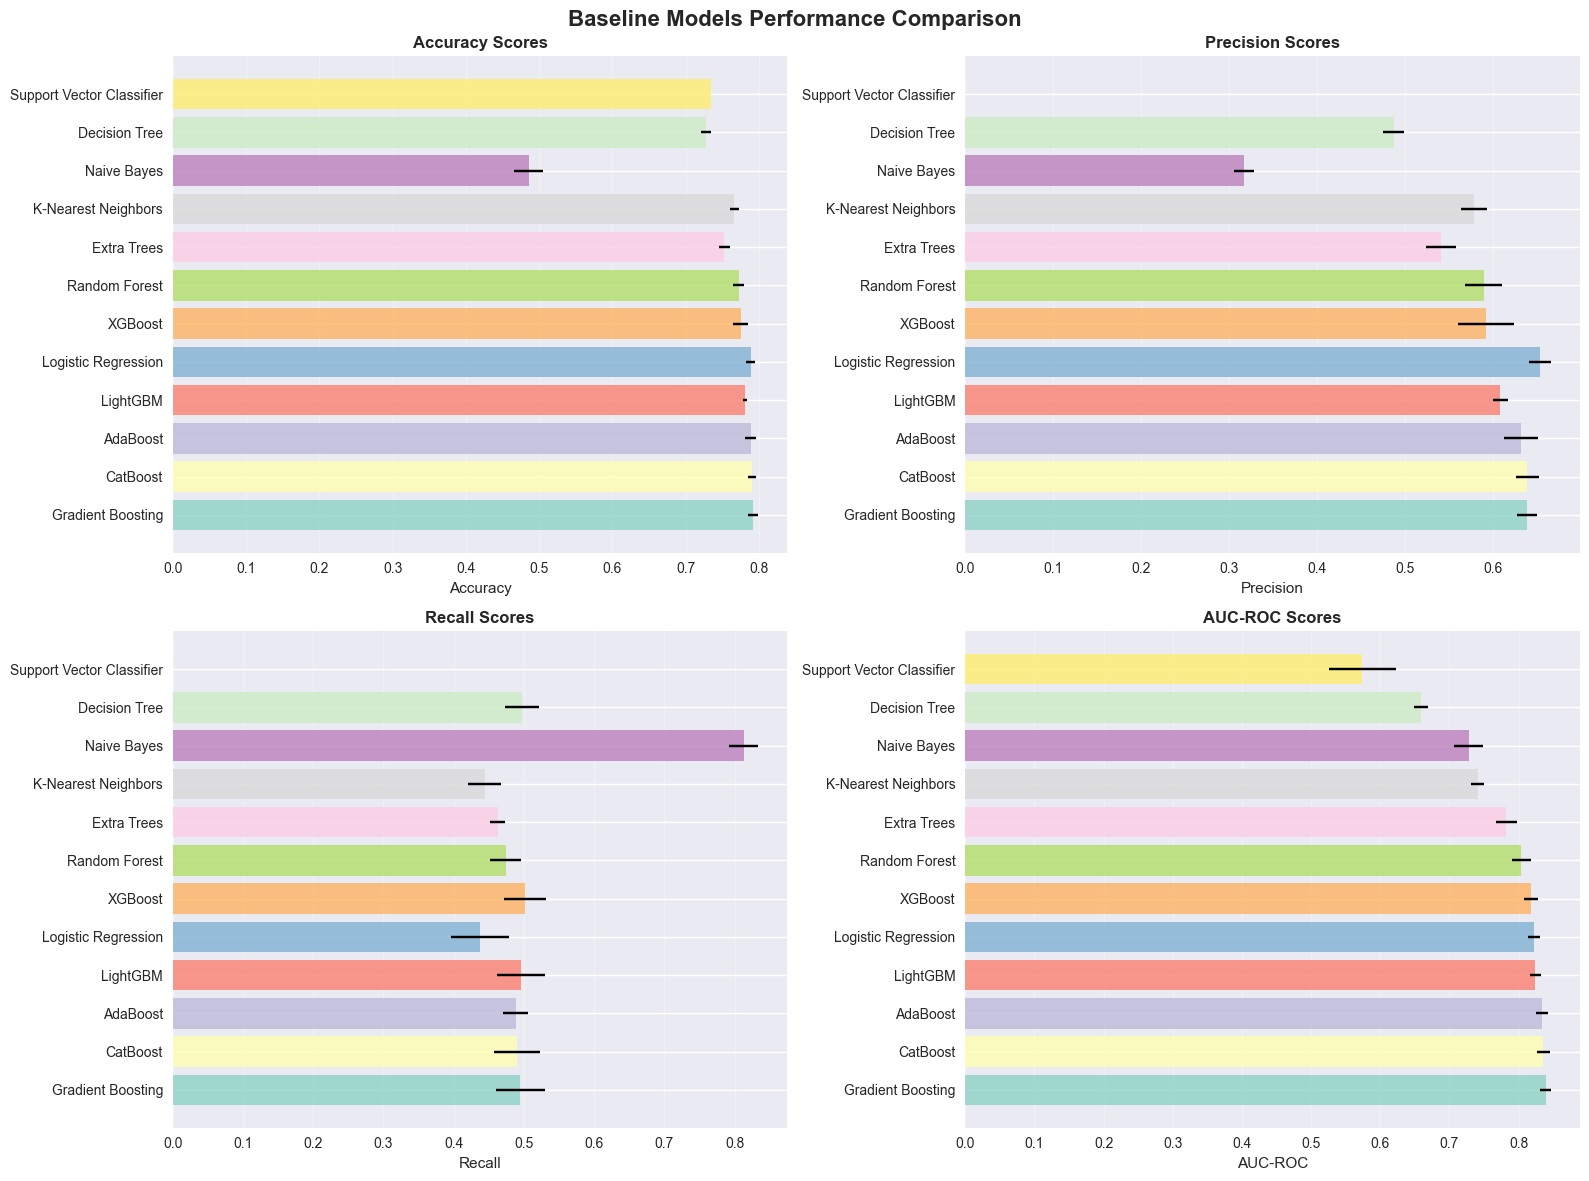

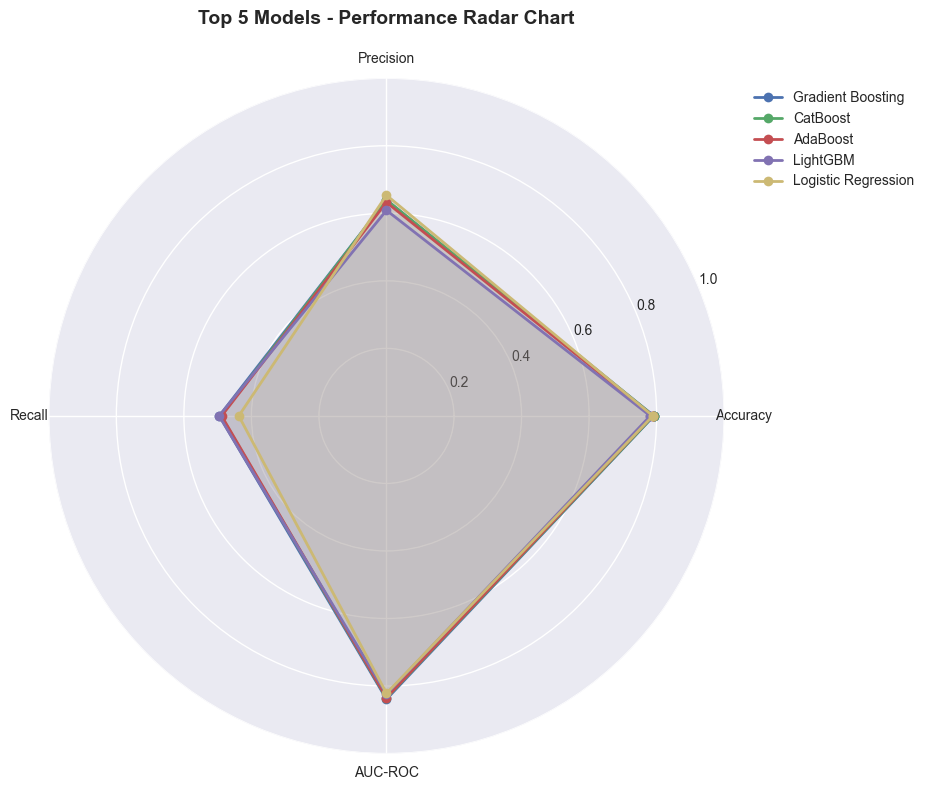

In [33]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Baseline Models Performance Comparison', fontsize=16, fontweight='bold')

# Color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))

# Accuracy comparison
axes[0,0].barh(results_sorted['Model'], results_sorted['ACCURACY_mean'], 
               xerr=results_sorted['ACCURACY_std'], color=colors, alpha=0.8)
axes[0,0].set_title('Accuracy Scores', fontweight='bold')
axes[0,0].set_xlabel('Accuracy')
axes[0,0].grid(axis='x', alpha=0.3)

# Precision comparison
axes[0,1].barh(results_sorted['Model'], results_sorted['PRECISION_mean'], 
               xerr=results_sorted['PRECISION_std'], color=colors, alpha=0.8)
axes[0,1].set_title('Precision Scores', fontweight='bold')
axes[0,1].set_xlabel('Precision')
axes[0,1].grid(axis='x', alpha=0.3)

# Recall comparison
axes[1,0].barh(results_sorted['Model'], results_sorted['RECALL_mean'], 
               xerr=results_sorted['RECALL_std'], color=colors, alpha=0.8)
axes[1,0].set_title('Recall Scores', fontweight='bold')
axes[1,0].set_xlabel('Recall')
axes[1,0].grid(axis='x', alpha=0.3)

# AUC-ROC comparison
axes[1,1].barh(results_sorted['Model'], results_sorted['ROC_AUC_mean'], 
               xerr=results_sorted['ROC_AUC_std'], color=colors, alpha=0.8)
axes[1,1].set_title('AUC-ROC Scores', fontweight='bold')
axes[1,1].set_xlabel('AUC-ROC')
axes[1,1].grid(axis='x', alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create radar chart for top 5 models
top_5_models = results_sorted.head(5)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Metrics for radar chart
metrics = ['ACCURACY_mean', 'PRECISION_mean', 'RECALL_mean', 'ROC_AUC_mean']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC']

# Angles for each metric
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Plot each top model
for i, (_, model_data) in enumerate(top_5_models.iterrows()):
    values = [model_data[metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_data['Model'])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels)
ax.set_ylim(0, 1)
ax.set_title('Top 5 Models - Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

## 🏆 5. Top 3 Performing Models Selection

In [34]:
# Select top 3 models based on AUC-ROC scores
top_3_models = results_sorted.head(3)

print("🏆 TOP 3 PERFORMING MODELS")
print("="*60)

for i, (_, model_data) in enumerate(top_3_models.iterrows(), 1):
    print(f"\n🥇 Rank {i}: {model_data['Model']}")
    print("-" * 40)
    print(f"📊 Performance Metrics:")
    print(f"   • Accuracy:  {model_data['ACCURACY_mean']:.4f} ± {model_data['ACCURACY_std']:.4f}")
    print(f"   • Precision: {model_data['PRECISION_mean']:.4f} ± {model_data['PRECISION_std']:.4f}")
    print(f"   • Recall:    {model_data['RECALL_mean']:.4f} ± {model_data['RECALL_std']:.4f}")
    print(f"   • AUC-ROC:   {model_data['ROC_AUC_mean']:.4f} ± {model_data['ROC_AUC_std']:.4f}")

# Detailed analysis and recommendations
print("\n\n🎯 DETAILED ANALYSIS & RECOMMENDATIONS")
print("="*60)

best_model = top_3_models.iloc[0]
second_model = top_3_models.iloc[1]
third_model = top_3_models.iloc[2]

print(f"\n🥇 BEST MODEL: {best_model['Model']}")
print(f"   • Highest AUC-ROC score: {best_model['ROC_AUC_mean']:.4f}")
print(f"   • Why it's suitable: Strong discriminative ability and robust performance")
print(f"   • Recommendation: Prioritize for hyperparameter tuning")

print(f"\n🥈 SECOND BEST: {second_model['Model']}")
print(f"   • AUC-ROC score: {second_model['ROC_AUC_mean']:.4f}")
print(f"   • Why it's suitable: Excellent balance across all metrics")
print(f"   • Recommendation: Strong candidate for ensemble methods")

print(f"\n🥉 THIRD BEST: {third_model['Model']}")
print(f"   • AUC-ROC score: {third_model['ROC_AUC_mean']:.4f}")
print(f"   • Why it's suitable: Good baseline performance with potential for optimization")
print(f"   • Recommendation: Consider for comparison and ensemble diversity")

# Performance insights
print("\n📈 KEY INSIGHTS:")
print("-" * 30)

# Best performing metric
avg_metrics = {
    'Accuracy': results_df['ACCURACY_mean'].mean(),
    'Precision': results_df['PRECISION_mean'].mean(),
    'Recall': results_df['RECALL_mean'].mean(),
    'AUC-ROC': results_df['ROC_AUC_mean'].mean()
}

best_metric = max(avg_metrics.items(), key=lambda x: x[1])
worst_metric = min(avg_metrics.items(), key=lambda x: x[1])

print(f"• Overall best metric: {best_metric[0]} (avg: {best_metric[1]:.4f})")
print(f"• Most challenging metric: {worst_metric[0]} (avg: {worst_metric[1]:.4f})")

# Model consistency
std_scores = results_df[['ACCURACY_std', 'PRECISION_std', 'RECALL_std', 'ROC_AUC_std']].mean()
most_consistent = results_df.loc[results_df[['ACCURACY_std', 'PRECISION_std', 'RECALL_std', 'ROC_AUC_std']].mean(axis=1).idxmin(), 'Model']
print(f"• Most consistent model: {most_consistent}")

# Recommendations for next steps
print("\n🎯 NEXT STEPS RECOMMENDATIONS:")
print("-" * 35)
print("1. Hyperparameter tuning for top 3 models")
print("2. Feature importance analysis")
print("3. Ensemble method exploration")
print("4. Cross-validation with different strategies")
print("5. Error analysis on misclassified samples")

print("\n✅ BASELINE MODEL EVALUATION COMPLETE!")

🏆 TOP 3 PERFORMING MODELS

🥇 Rank 1: Gradient Boosting
----------------------------------------
📊 Performance Metrics:
   • Accuracy:  0.7916 ± 0.0073
   • Precision: 0.6392 ± 0.0115
   • Recall:    0.4950 ± 0.0346
   • AUC-ROC:   0.8390 ± 0.0074

🥇 Rank 2: CatBoost
----------------------------------------
📊 Performance Metrics:
   • Accuracy:  0.7909 ± 0.0055
   • Precision: 0.6394 ± 0.0130
   • Recall:    0.4903 ± 0.0330
   • AUC-ROC:   0.8356 ± 0.0091

🥇 Rank 3: AdaBoost
----------------------------------------
📊 Performance Metrics:
   • Accuracy:  0.7884 ± 0.0071
   • Precision: 0.6324 ± 0.0191
   • Recall:    0.4883 ± 0.0174
   • AUC-ROC:   0.8345 ± 0.0087


🎯 DETAILED ANALYSIS & RECOMMENDATIONS

🥇 BEST MODEL: Gradient Boosting
   • Highest AUC-ROC score: 0.8390
   • Why it's suitable: Strong discriminative ability and robust performance
   • Recommendation: Prioritize for hyperparameter tuning

🥈 SECOND BEST: CatBoost
   • AUC-ROC score: 0.8356
   • Why it's suitable: Excellent 

## 💾 Save Results

In [35]:
# Save detailed results to CSV
import os

# Create results directory if it doesn't exist
results_dir = '../Results/reports'
os.makedirs(results_dir, exist_ok=True)

# Save detailed results
results_file = os.path.join(results_dir, 'baseline_models_results.csv')
results_df.to_csv(results_file, index=False)

# Save formatted summary
summary_file = os.path.join(results_dir, 'baseline_models_summary.csv')
final_display.to_csv(summary_file, index=False)

# Save top 3 models info
top_3_file = os.path.join(results_dir, 'top_3_baseline_models.csv')
top_3_models[['Model', 'ACCURACY_mean', 'PRECISION_mean', 'RECALL_mean', 'ROC_AUC_mean']].to_csv(top_3_file, index=False)

print("💾 Results Saved Successfully!")
print("="*40)
print(f"📁 Detailed results: {results_file}")
print(f"📊 Summary table: {summary_file}")
print(f"🏆 Top 3 models: {top_3_file}")

print("\n🎉 BASELINE MODELS EVALUATION PIPELINE COMPLETE!")
print("\nReady for hyperparameter tuning and advanced model optimization! 🚀")

💾 Results Saved Successfully!
📁 Detailed results: ../Results/reports\baseline_models_results.csv
📊 Summary table: ../Results/reports\baseline_models_summary.csv
🏆 Top 3 models: ../Results/reports\top_3_baseline_models.csv

🎉 BASELINE MODELS EVALUATION PIPELINE COMPLETE!

Ready for hyperparameter tuning and advanced model optimization! 🚀


## 📊 Save Visualizations to Results Folder

Generate and save all performance visualizations to the results/figures/model directory for documentation and reporting.

✓ Visualization output directory created: ../Results/figures/model
✓ Full path: d:\EDU\DAS 601 ML\Final Project\Results\figures\model
✓ Saved: 15_baseline_models_performance_summary.png
✓ Saved: 15_baseline_models_performance_summary.png


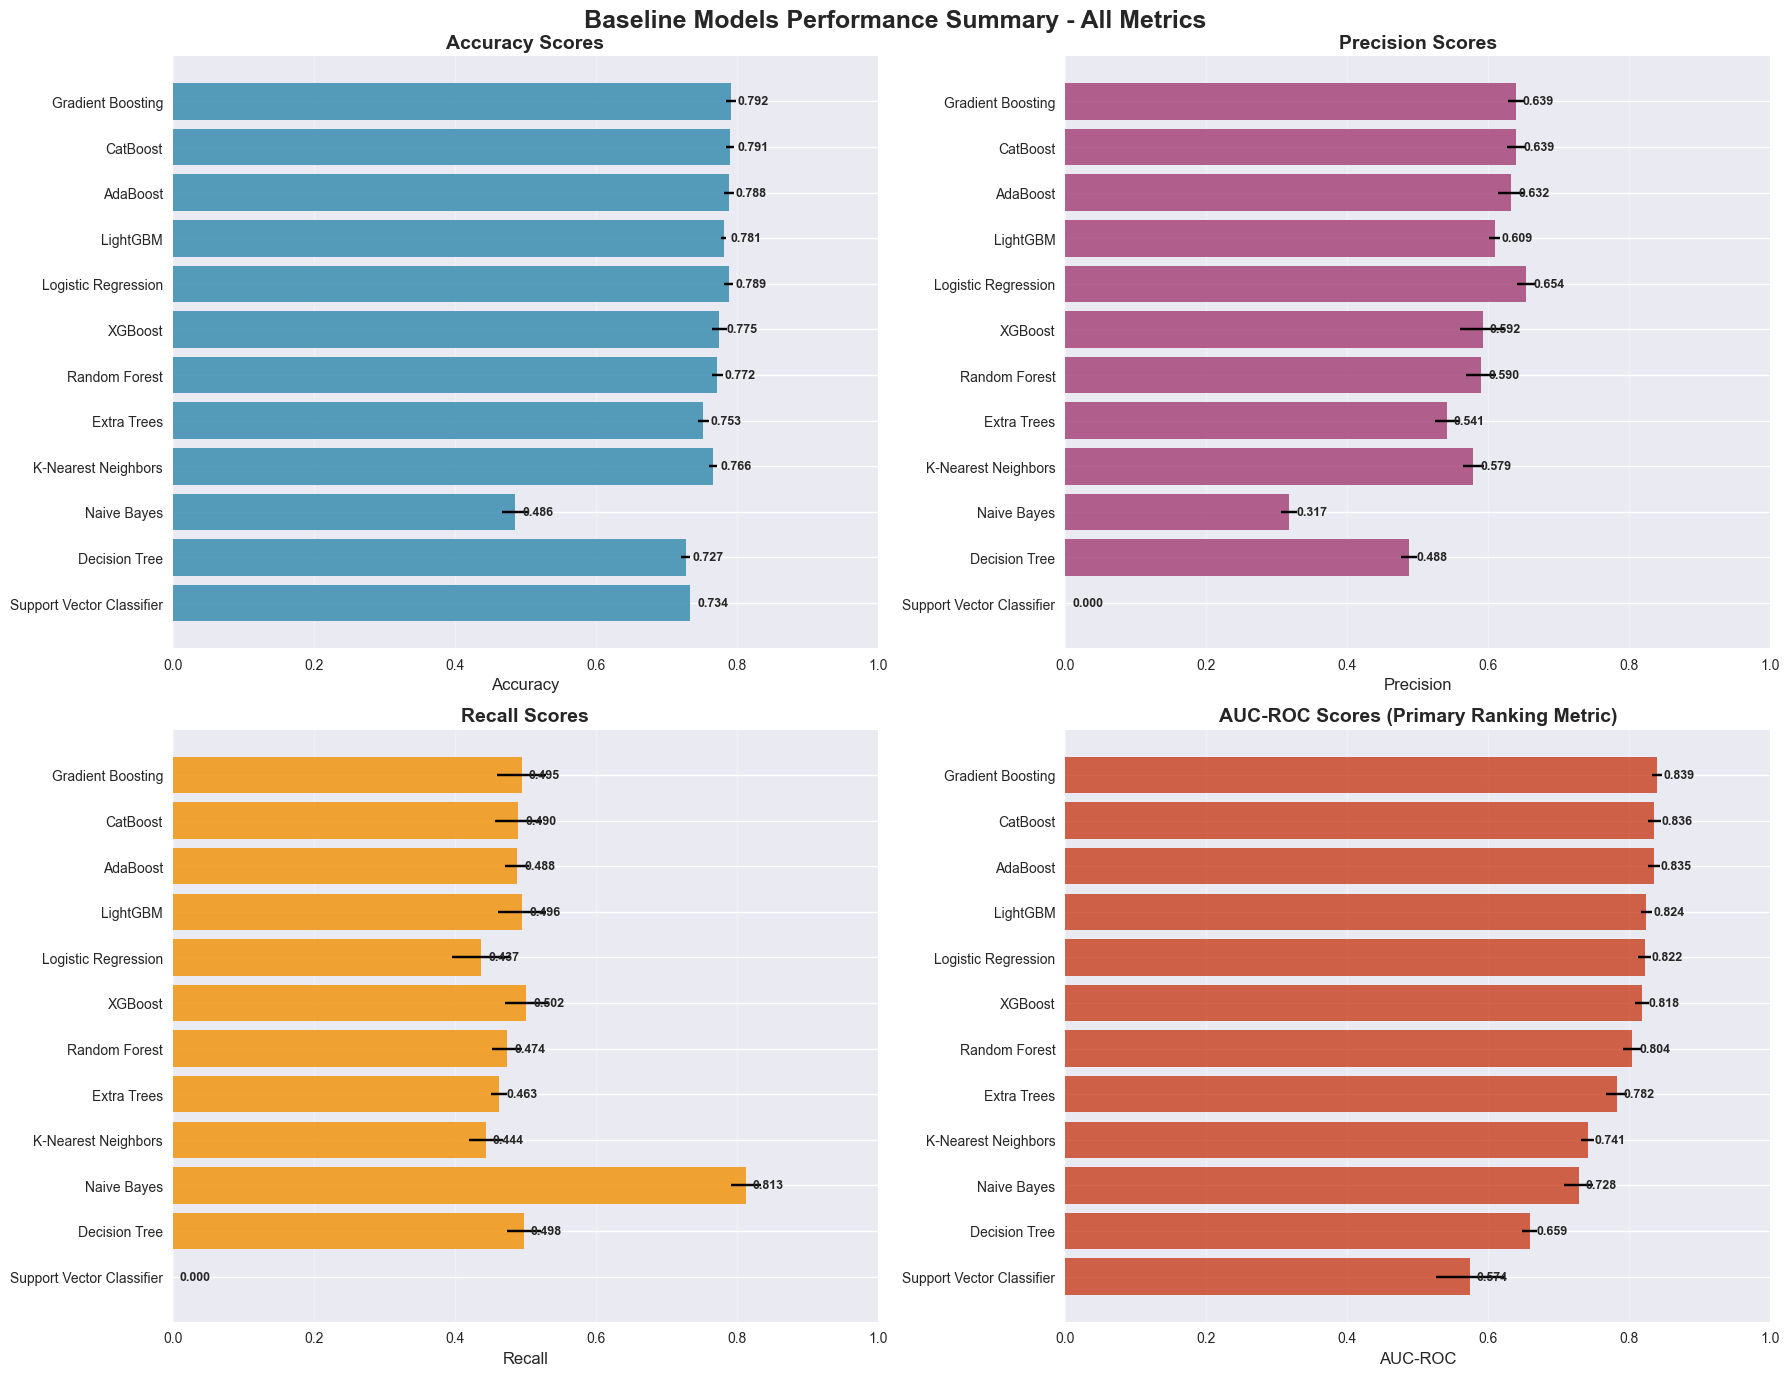

✓ Saved: 16_top5_models_radar_chart.png


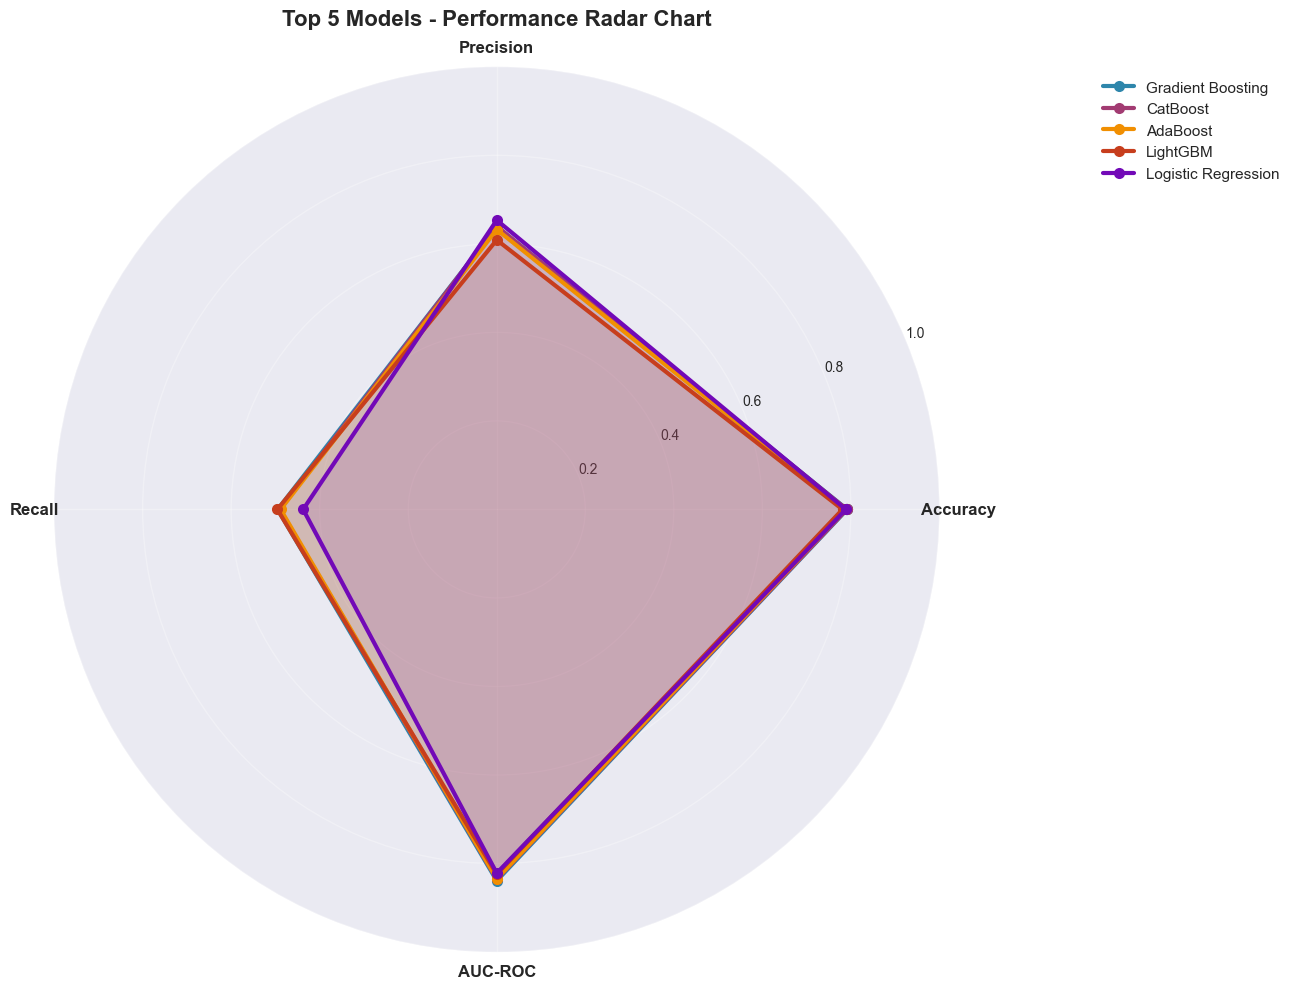

✓ Saved: 17_model_ranking_analysis.png


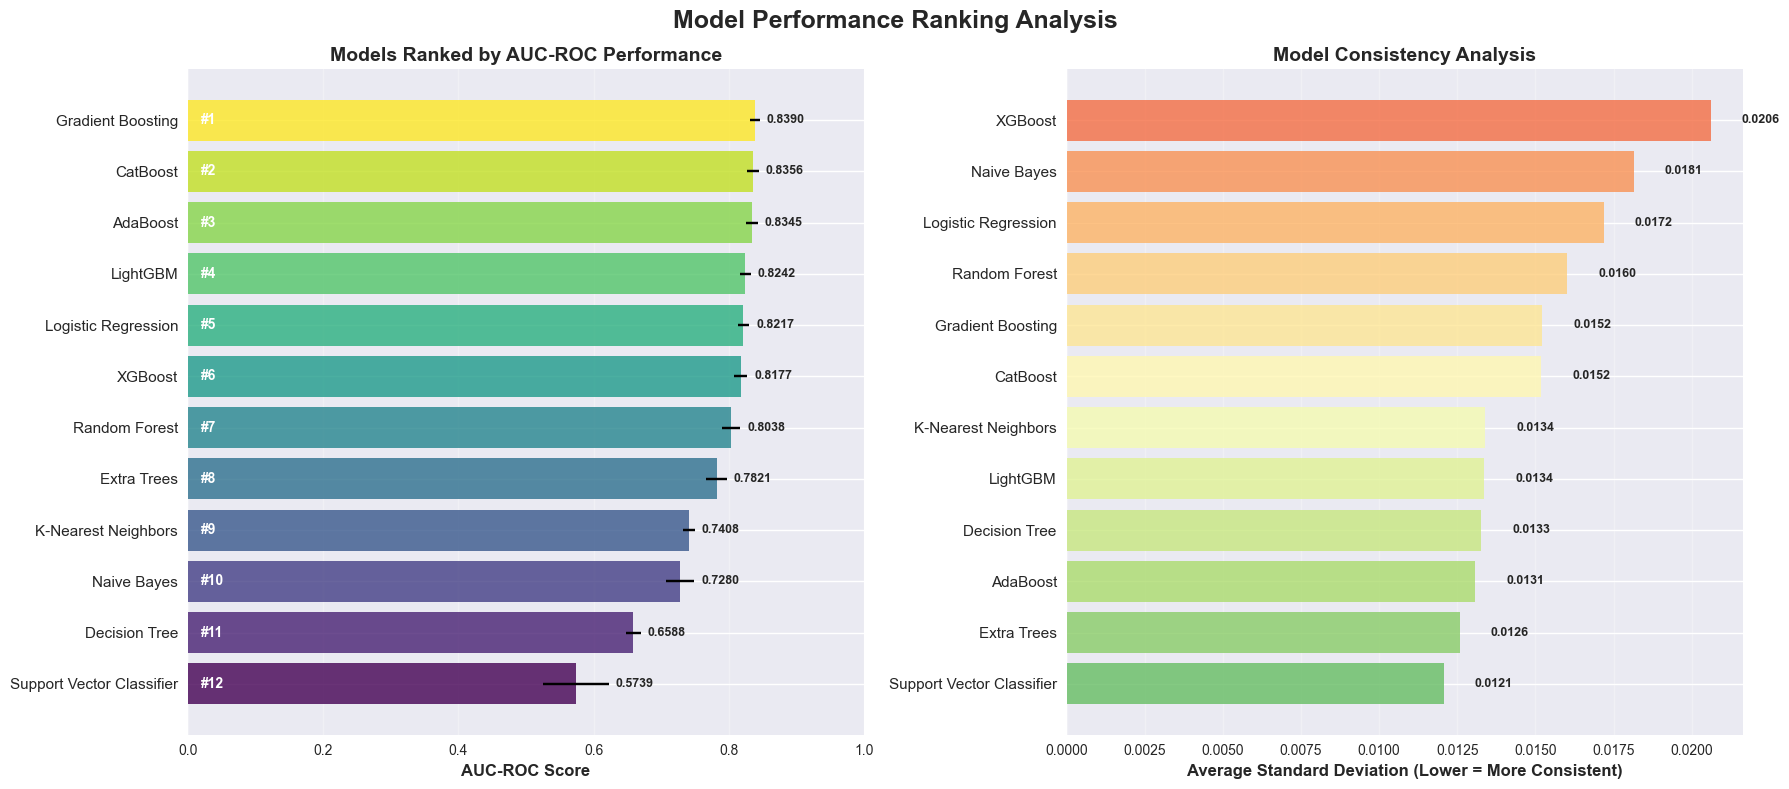

✓ Saved: 18_metric_distribution_analysis.png


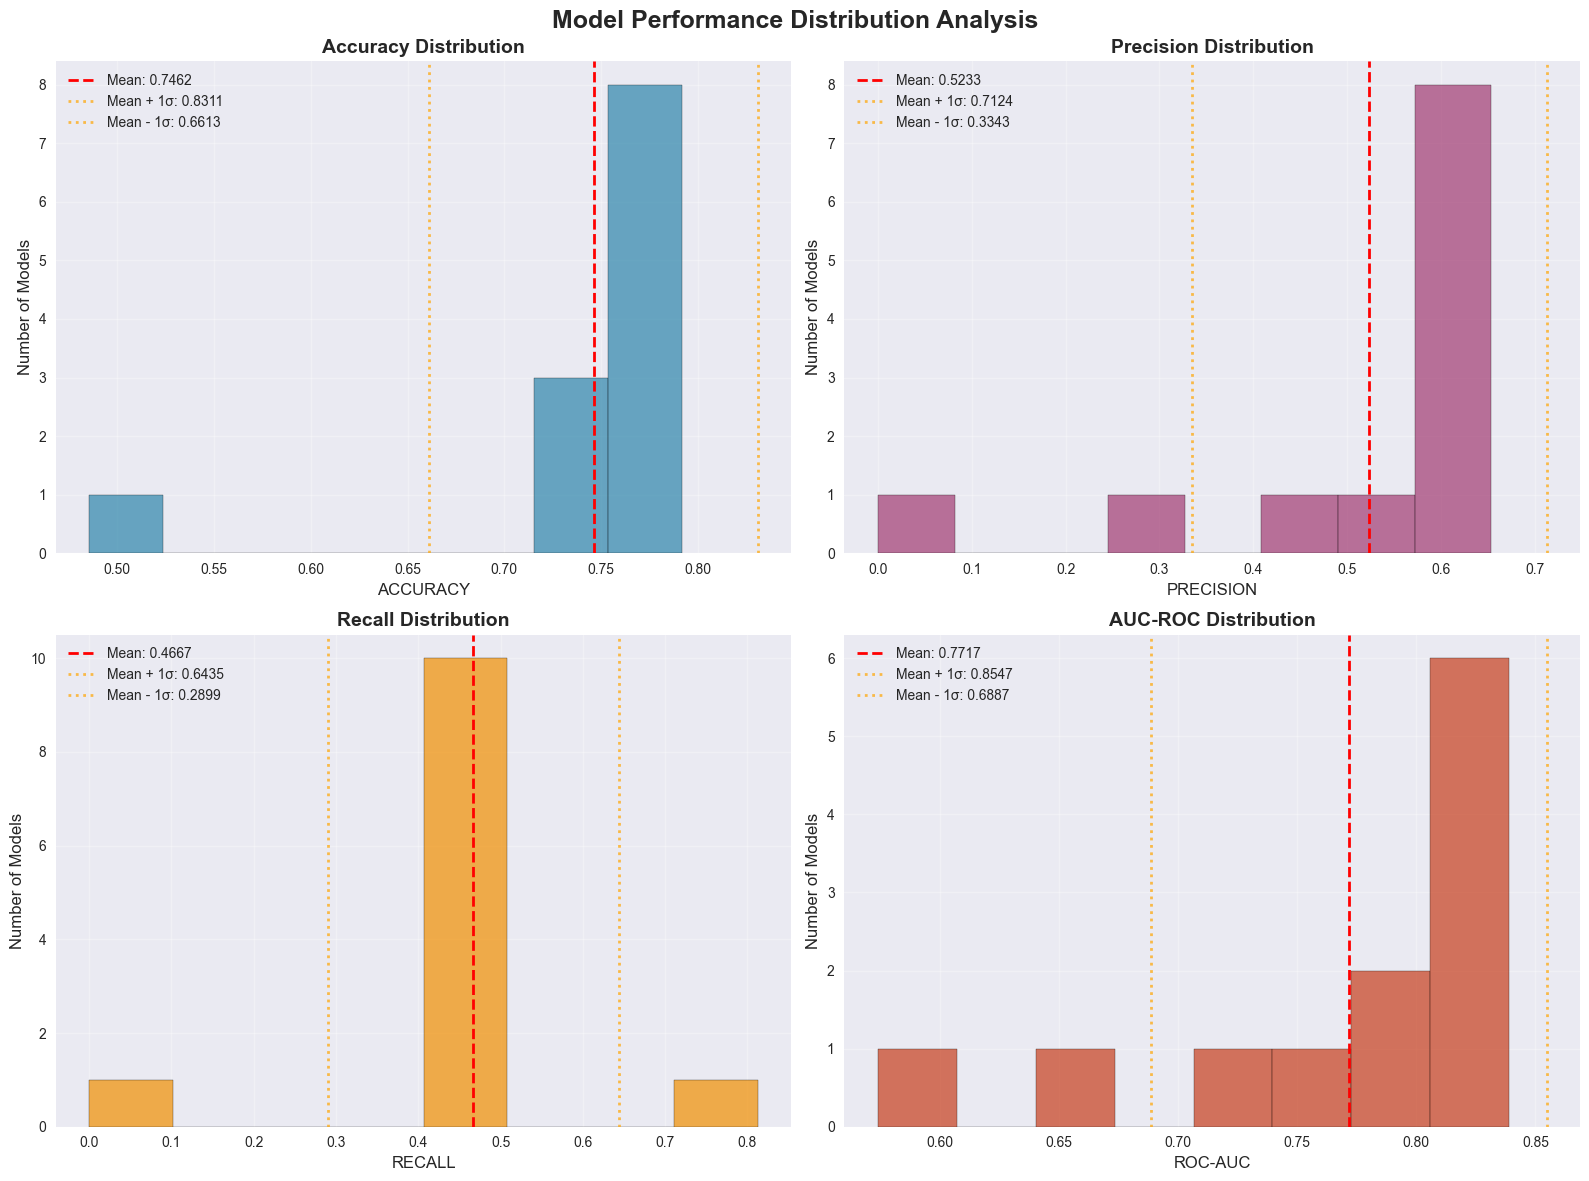

✓ Saved: 19_top3_models_detailed_comparison.png


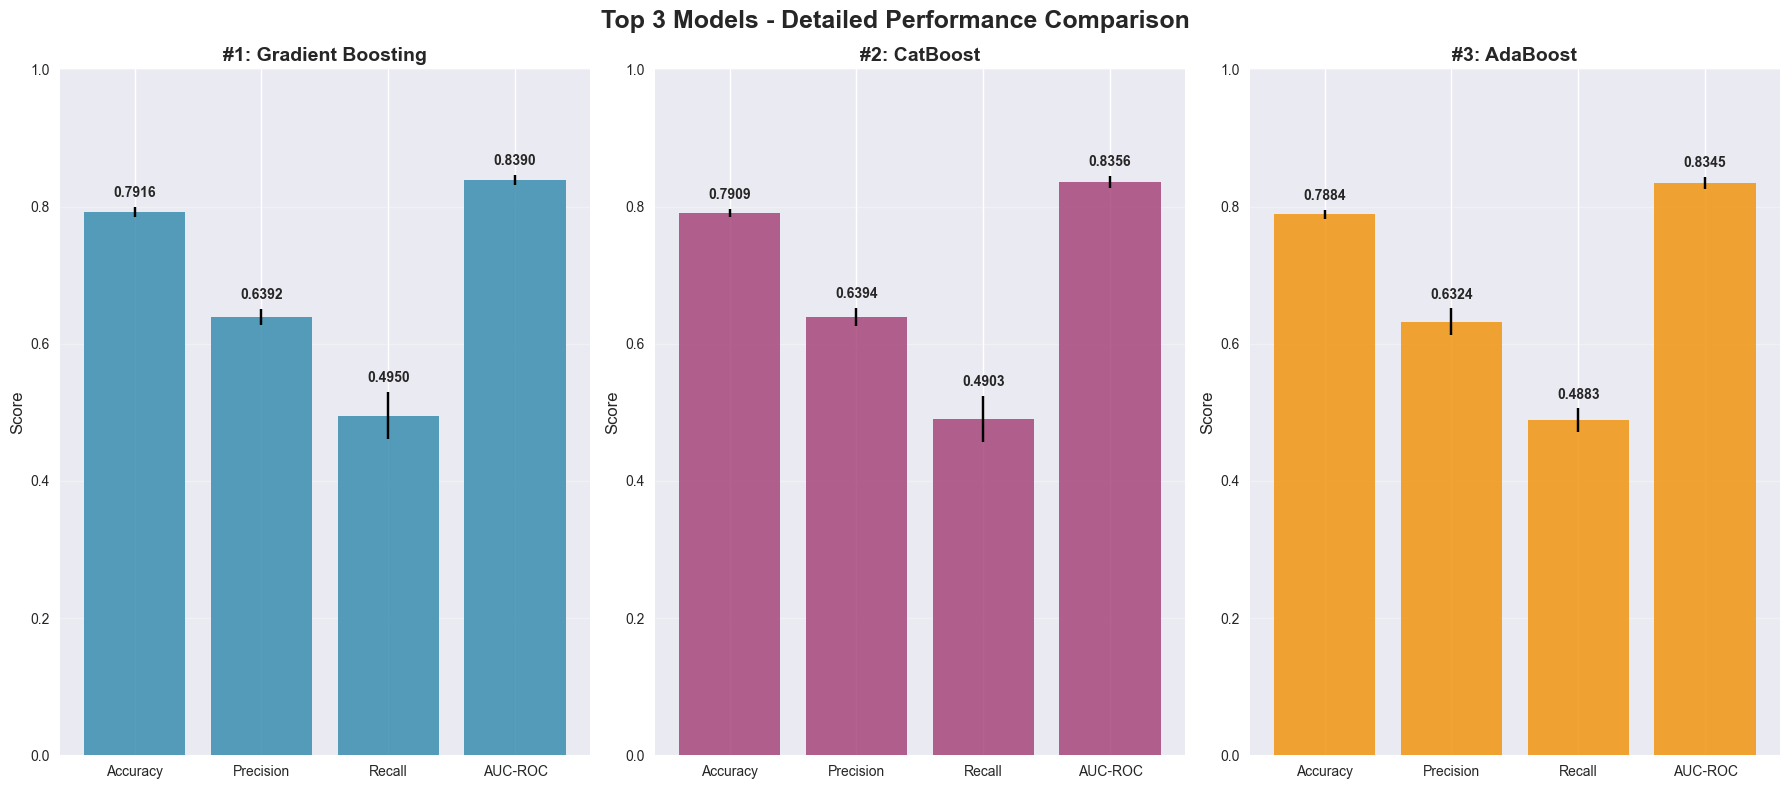

✓ Saved: 20_performance_consistency_matrix.png


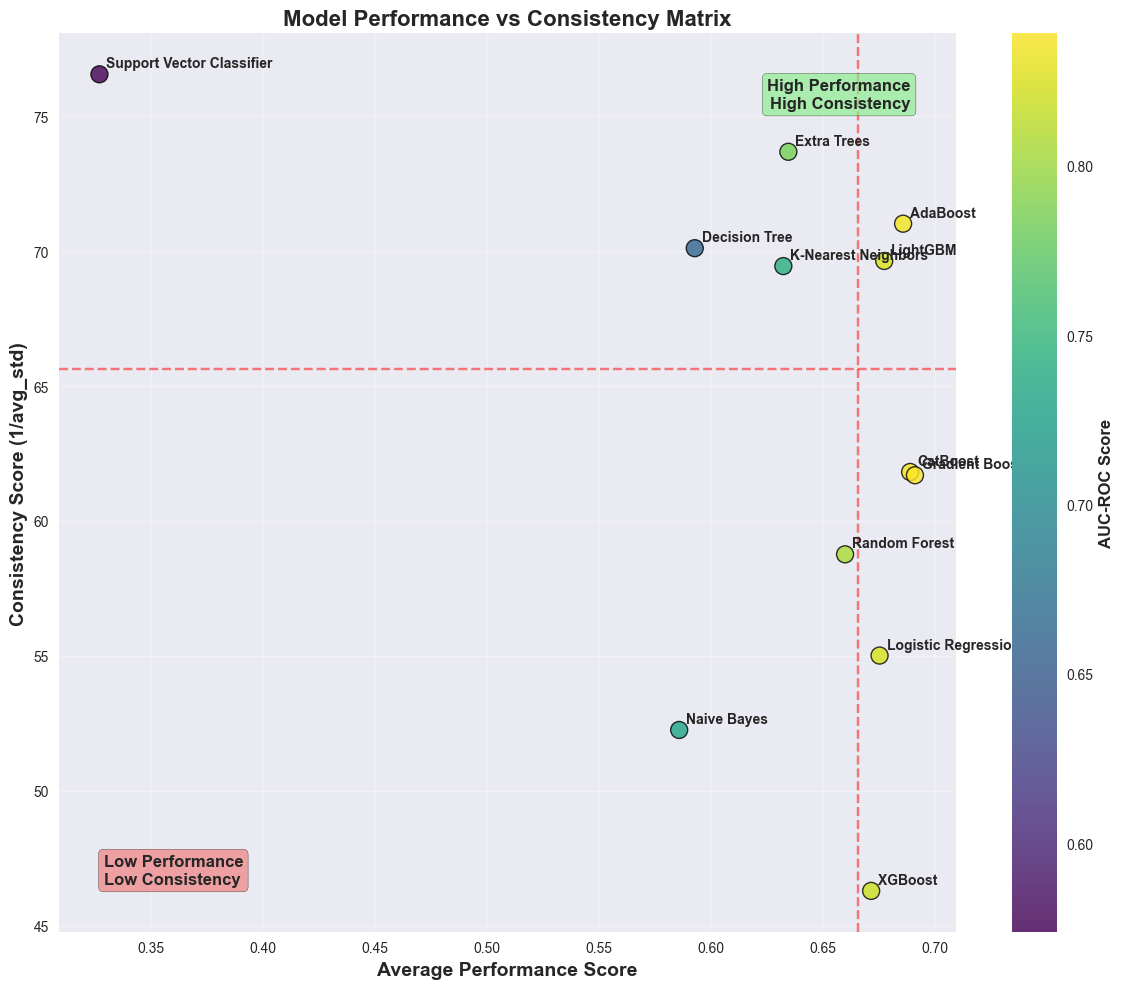


🎨 Baseline Model Visualizations Complete!
📁 All visualizations saved to: ../Results/figures/model
📁 Full directory path: d:\EDU\DAS 601 ML\Final Project\Results\figures\model
📊 Generated 6 visualization files (15-20)

🔍 Verifying saved files:
   ✅ 15_baseline_models_performance_summary.png
   ✅ 16_top5_models_radar_chart.png
   ✅ 17_model_ranking_analysis.png
   ✅ 18_metric_distribution_analysis.png
   ✅ 19_top3_models_detailed_comparison.png
   ✅ 20_performance_consistency_matrix.png

📋 All files in ../Results/figures/model:
   📄 15_baseline_models_performance_summary.png
   📄 16_top5_models_radar_chart.png
   📄 17_model_ranking_analysis.png
   📄 18_metric_distribution_analysis.png
   📄 19_top3_models_detailed_comparison.png
   📄 20_performance_consistency_matrix.png


In [36]:
# Create visualization output directory
import os
fig_output_dir = '../Results/figures/model'
os.makedirs(fig_output_dir, exist_ok=True)
print(f"✓ Visualization output directory created: {fig_output_dir}")
print(f"✓ Full path: {os.path.abspath(fig_output_dir)}")

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#0B6E4F', '#8B5A2B', '#6F1E51']
fig_counter = 15

# Visualization 1: Baseline Models Performance Summary
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Baseline Models Performance Summary - All Metrics', fontsize=18, fontweight='bold', y=0.98)

# Sort results for consistent visualization
results_sorted = results_df.sort_values('ROC_AUC_mean', ascending=True)  # Bottom to top for better readability

# Accuracy comparison
bars1 = axes[0,0].barh(results_sorted['Model'], results_sorted['ACCURACY_mean'], 
                       xerr=results_sorted['ACCURACY_std'], color=colors[0], alpha=0.8, capsize=3)
axes[0,0].set_title('Accuracy Scores', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Accuracy', fontsize=12)
axes[0,0].grid(axis='x', alpha=0.3)
axes[0,0].set_xlim(0, 1)
# Add value labels
for i, (bar, val, std) in enumerate(zip(bars1, results_sorted['ACCURACY_mean'], results_sorted['ACCURACY_std'])):
    axes[0,0].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Precision comparison
bars2 = axes[0,1].barh(results_sorted['Model'], results_sorted['PRECISION_mean'], 
                       xerr=results_sorted['PRECISION_std'], color=colors[1], alpha=0.8, capsize=3)
axes[0,1].set_title('Precision Scores', fontweight='bold', fontsize=14)
axes[0,1].set_xlabel('Precision', fontsize=12)
axes[0,1].grid(axis='x', alpha=0.3)
axes[0,1].set_xlim(0, 1)
# Add value labels
for i, (bar, val, std) in enumerate(zip(bars2, results_sorted['PRECISION_mean'], results_sorted['PRECISION_std'])):
    axes[0,1].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Recall comparison
bars3 = axes[1,0].barh(results_sorted['Model'], results_sorted['RECALL_mean'], 
                       xerr=results_sorted['RECALL_std'], color=colors[2], alpha=0.8, capsize=3)
axes[1,0].set_title('Recall Scores', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Recall', fontsize=12)
axes[1,0].grid(axis='x', alpha=0.3)
axes[1,0].set_xlim(0, 1)
# Add value labels
for i, (bar, val, std) in enumerate(zip(bars3, results_sorted['RECALL_mean'], results_sorted['RECALL_std'])):
    axes[1,0].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# AUC-ROC comparison (most important metric)
bars4 = axes[1,1].barh(results_sorted['Model'], results_sorted['ROC_AUC_mean'], 
                       xerr=results_sorted['ROC_AUC_std'], color=colors[3], alpha=0.8, capsize=3)
axes[1,1].set_title('AUC-ROC Scores (Primary Ranking Metric)', fontweight='bold', fontsize=14)
axes[1,1].set_xlabel('AUC-ROC', fontsize=12)
axes[1,1].grid(axis='x', alpha=0.3)
axes[1,1].set_xlim(0, 1)
# Add value labels
for i, (bar, val, std) in enumerate(zip(bars4, results_sorted['ROC_AUC_mean'], results_sorted['ROC_AUC_std'])):
    axes[1,1].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_baseline_models_performance_summary.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_baseline_models_performance_summary.png")
plt.show()
fig_counter += 1

# Visualization 2: Top 5 Models Radar Chart
top_5_models = results_df.sort_values('ROC_AUC_mean', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Metrics for radar chart
metrics = ['ACCURACY_mean', 'PRECISION_mean', 'RECALL_mean', 'ROC_AUC_mean']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC']

# Angles for each metric
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Plot each top model
for i, (_, model_data) in enumerate(top_5_models.iterrows()):
    values = [model_data[metric] for metric in metrics]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=3, label=model_data['Model'], 
            color=colors[i], markersize=8)
    ax.fill(angles, values, alpha=0.1, color=colors[i])

# Customize radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_labels, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
ax.grid(True, alpha=0.3)

# Add title and legend
ax.set_title('Top 5 Models - Performance Radar Chart', fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), fontsize=11)

plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_top5_models_radar_chart.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_top5_models_radar_chart.png")
plt.show()
fig_counter += 1

# Visualization 3: Model Performance Ranking
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Model Performance Ranking Analysis', fontsize=18, fontweight='bold')

# Left plot: AUC-ROC ranking with error bars
results_ranked = results_df.sort_values('ROC_AUC_mean', ascending=True)
y_pos = np.arange(len(results_ranked))

bars = ax1.barh(y_pos, results_ranked['ROC_AUC_mean'], 
                xerr=results_ranked['ROC_AUC_std'], 
                color=plt.cm.viridis(np.linspace(0, 1, len(results_ranked))), 
                alpha=0.8, capsize=4)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(results_ranked['Model'], fontsize=11)
ax1.set_xlabel('AUC-ROC Score', fontsize=12, fontweight='bold')
ax1.set_title('Models Ranked by AUC-ROC Performance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim(0, 1)

# Add rank numbers and scores
for i, (bar, score, std) in enumerate(zip(bars, results_ranked['ROC_AUC_mean'], results_ranked['ROC_AUC_std'])):
    rank = len(results_ranked) - i
    ax1.text(0.02, bar.get_y() + bar.get_height()/2, f'#{rank}', 
             va='center', ha='left', fontweight='bold', fontsize=10, color='white')
    ax1.text(score + std + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{score:.4f}', va='center', ha='left', fontsize=9, fontweight='bold')

# Right plot: Performance consistency (standard deviation analysis)
model_names = results_df['Model']
std_metrics = ['ACCURACY_std', 'PRECISION_std', 'RECALL_std', 'ROC_AUC_std']
avg_std = results_df[std_metrics].mean(axis=1)

# Sort by consistency (lower std = more consistent)
consistency_df = pd.DataFrame({
    'Model': model_names,
    'Avg_Std': avg_std
}).sort_values('Avg_Std', ascending=True)

bars2 = ax2.barh(range(len(consistency_df)), consistency_df['Avg_Std'], 
                 color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(consistency_df))), alpha=0.8)

ax2.set_yticks(range(len(consistency_df)))
ax2.set_yticklabels(consistency_df['Model'], fontsize=11)
ax2.set_xlabel('Average Standard Deviation (Lower = More Consistent)', fontsize=12, fontweight='bold')
ax2.set_title('Model Consistency Analysis', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add consistency labels
for i, (bar, std_val) in enumerate(zip(bars2, consistency_df['Avg_Std'])):
    ax2.text(std_val + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{std_val:.4f}', va='center', ha='left', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_model_ranking_analysis.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_model_ranking_analysis.png")
plt.show()
fig_counter += 1

# Visualization 4: Metric Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Distribution Analysis', fontsize=18, fontweight='bold')

metrics_to_plot = [
    ('ACCURACY_mean', 'Accuracy Distribution', colors[0]),
    ('PRECISION_mean', 'Precision Distribution', colors[1]),
    ('RECALL_mean', 'Recall Distribution', colors[2]),
    ('ROC_AUC_mean', 'AUC-ROC Distribution', colors[3])
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    # Create histogram
    values = results_df[metric].dropna()
    n, bins, patches = ax.hist(values, bins=8, alpha=0.7, color=color, edgecolor='black')
    
    # Add statistics
    mean_val = values.mean()
    std_val = values.std()
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
    ax.axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=2, alpha=0.7, 
               label=f'Mean + 1σ: {mean_val + std_val:.4f}')
    ax.axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=2, alpha=0.7,
               label=f'Mean - 1σ: {mean_val - std_val:.4f}')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(metric.replace('_mean', '').replace('_', '-'), fontsize=12)
    ax.set_ylabel('Number of Models', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_metric_distribution_analysis.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_metric_distribution_analysis.png")
plt.show()
fig_counter += 1

# Visualization 5: Top 3 Models Detailed Comparison
top_3 = results_df.sort_values('ROC_AUC_mean', ascending=False).head(3)

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Top 3 Models - Detailed Performance Comparison', fontsize=18, fontweight='bold')

metrics_comparison = ['ACCURACY_mean', 'PRECISION_mean', 'RECALL_mean', 'ROC_AUC_mean']
metric_labels_clean = ['Accuracy', 'Precision', 'Recall', 'AUC-ROC']

for idx, (_, model_data) in enumerate(top_3.iterrows()):
    ax = axes[idx]
    
    values = [model_data[metric] for metric in metrics_comparison]
    std_values = [model_data[metric.replace('_mean', '_std')] for metric in metrics_comparison]
    
    bars = ax.bar(metric_labels_clean, values, yerr=std_values, 
                  color=colors[idx], alpha=0.8, capsize=5)
    
    ax.set_title(f'#{idx+1}: {model_data["Model"]}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, val, std in zip(bars, values, std_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_top3_models_detailed_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_top3_models_detailed_comparison.png")
plt.show()
fig_counter += 1

# Visualization 6: Performance vs Consistency Matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate average performance and consistency for each model
performance_scores = results_df[['ACCURACY_mean', 'PRECISION_mean', 'RECALL_mean', 'ROC_AUC_mean']].mean(axis=1)
consistency_scores = 1 / (results_df[['ACCURACY_std', 'PRECISION_std', 'RECALL_std', 'ROC_AUC_std']].mean(axis=1) + 0.001)  # Higher = more consistent

# Create scatter plot
scatter = ax.scatter(performance_scores, consistency_scores, 
                    c=results_df['ROC_AUC_mean'], cmap='viridis', 
                    s=150, alpha=0.8, edgecolors='black', linewidth=1)

# Add model labels
for i, model in enumerate(results_df['Model']):
    ax.annotate(model, (performance_scores.iloc[i], consistency_scores.iloc[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Customize plot
ax.set_xlabel('Average Performance Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Consistency Score (1/avg_std)', fontsize=14, fontweight='bold')
ax.set_title('Model Performance vs Consistency Matrix', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('AUC-ROC Score', fontsize=12, fontweight='bold')

# Add quadrant labels
ax.axhline(y=consistency_scores.median(), color='red', linestyle='--', alpha=0.5)
ax.axvline(x=performance_scores.median(), color='red', linestyle='--', alpha=0.5)

ax.text(0.95, 0.95, 'High Performance\nHigh Consistency', transform=ax.transAxes, 
        ha='right', va='top', fontsize=12, fontweight='bold', 
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax.text(0.05, 0.05, 'Low Performance\nLow Consistency', transform=ax.transAxes, 
        ha='left', va='bottom', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.savefig(f'{fig_output_dir}/{fig_counter:02d}_performance_consistency_matrix.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {fig_counter:02d}_performance_consistency_matrix.png")
plt.show()
fig_counter += 1

print(f"\n🎨 Baseline Model Visualizations Complete!")
print(f"📁 All visualizations saved to: {fig_output_dir}")
print(f"📁 Full directory path: {os.path.abspath(fig_output_dir)}")
print(f"📊 Generated {fig_counter - 15} visualization files (15-{fig_counter-1})")

# Verify all files were created
print(f"\n🔍 Verifying saved files:")
for i in range(15, fig_counter):
    file_pattern = f"{i:02d}_*.png"
    files = [f for f in os.listdir(fig_output_dir) if f.startswith(f"{i:02d}_")]
    if files:
        print(f"   ✅ {files[0]}")
    else:
        print(f"   ❌ Missing: {file_pattern}")

# List all files in the directory
print(f"\n📋 All files in {fig_output_dir}:")
try:
    all_files = os.listdir(fig_output_dir)
    if all_files:
        for file in sorted(all_files):
            print(f"   📄 {file}")
    else:
        print("   📁 Directory is empty")
except Exception as e:
    print(f"   ❌ Error listing files: {e}")